# <span style="color:green"> Monoasset test: Interpolation of market data </span>

In [20]:
from pricing import EquityForwardCurve, DiscountingCurve, Black, ForwardVariance, Vanilla_PayOff
import numpy as np
import matplotlib.pyplot as plt
from scipy import log, sqrt, exp
from montecarlo import MC
import lets_be_rational.LetsBeRational as lbr

### Parameters of Simulation

In [21]:
t = 0
spot_price = 180
N_simulations = 5e5
T_max = 10
r = 1./100

### Market Data

Forward interest rate time grid [ 0.01  5.   10.  ]
Forward interest rate:  [0.01 0.01 0.01]


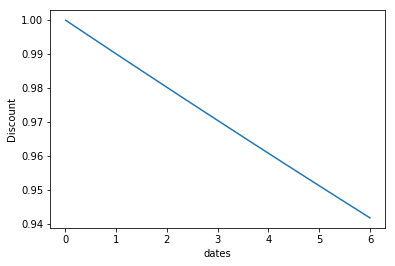

In [22]:
"""Discounut Factors"""
zero_interest_rate = np.array([r,r,r])
zero_interest_rate_dates = np.array([0.01,5,T_max])
d = exp(-zero_interest_rate*zero_interest_rate_dates)        #market discount factors 
D = DiscountingCurve(reference=t, discounts=d, dates=zero_interest_rate_dates)   #discounting curve
x = np.linspace(0.006,6,100)
plt.plot(x,D(x))
plt.xlabel("dates")
plt.ylabel("Discount")
plt.show()

Forward repo time grid [ 0.1 10. ]
Forward repo rate:  [0. 0.]


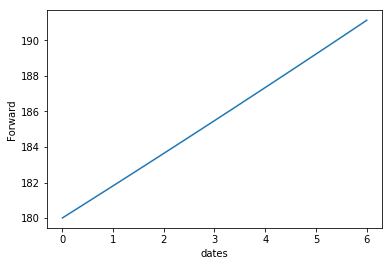

In [23]:
"""Create a Forward Curve with 0 repo_zero_rate"""
F = EquityForwardCurve(reference=t, discounting_curve=D, spot=spot_price,repo_dates=np.array([0.1,T_max]), repo_rates=np.array([0.,0.]))
plt.plot(x,F(x))
plt.xlabel("dates")
plt.ylabel("Forward")
plt.show()

In [24]:
#the implied volatility data for NVIDIA as of 31 January 2014
T = np.array([0.08,0.17,0.25,0.33,0.42,0.50,1.0,2.0,3.0])
K = np.array([157,164,172,180])
sigma = np.array(([32.2,29.3,29.1,29.5,29.7,29.8,29.9,30.6,30.62],[32,29.1,28.9,29.3,29.4,29.4,29.6,30.6,30.63],[33.6,29.3,29,29.3,29.3,29.3,29.3,30.6,30.59],[35,29.7,29.4,29.5,29.4,29.3,29.3,30.5,30.46]))
sigma = sigma/100
V = ForwardVariance(reference=0,maturities=T,strikes=K,spot_volatility=sigma,strike_interp=spot_price)

Forward volatility time grid:  [0.08 0.17 0.25 0.33 0.42 0.5  1.   2.   3.  ]
Forward volatility:  [0.35       0.24026675 0.28752109 0.29810338 0.29030386 0.28769298
 0.293      0.31654542 0.30379842]


### Simulation

In [25]:
BS = Black(forward_curve=F,variance=V)

In [26]:
maturities = np.array([0.08,0.17,0.25,0.33,0.42,0.50,1.0,2.0,3.0])
S_t = BS.simulate(Nsim=N_simulations,fixings=maturities)
kind = 1

Single Asset Simulation


In [27]:
X_t = S_t/F(T)
pay = Vanilla_PayOff(St=X_t, strike=spot_price/F(T), typo=kind)
result,err = MC(pay)
E = np.mean(X_t,axis=0)

In [28]:
imp_volatility = np.zeros(len(T))
imp_volatility_plus = np.zeros(len(T))
imp_volatility_minus = np.zeros(len(T))
for i in range (len(T)):
    imp_volatility[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i],E[i],spot_price/F(T[i]),T[i],kind)
    imp_volatility_minus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]-err[i],E[i],spot_price/F(T[i]),T[i],kind)
    imp_volatility_plus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]+err[i],E[i],spot_price/F(T[i]),T[i],kind)

In [29]:
y_lower = np.zeros(len(T))
y_upper =np.zeros(len(T))
for i in range(len(T)):
    if(imp_volatility_minus[i]<imp_volatility_plus[i]):
        y_lower[i]= abs(imp_volatility[i]-imp_volatility_minus[i])
        y_upper[i]= abs(imp_volatility_plus[i]-imp_volatility[i])
    elif(imp_volatility_minus[i]>imp_volatility_plus[i]):
        y_lower[i][j] = abs(imp_volatility[i][j]-imp_volatility_plus[i])
        y_upper[i][j] = abs(imp_volatility_minus[i]-imp_volatility[i])

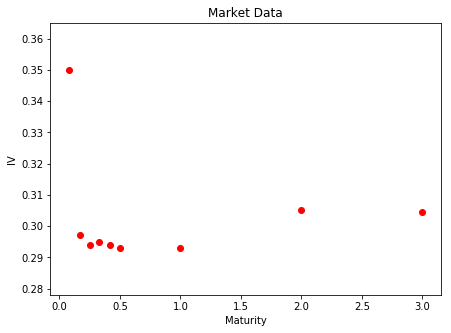

In [30]:
plt.figure(figsize=(7,5))
plt.scatter(T,sigma[len(sigma)-1],color="Red")
plt.title("Market Data")
plt.xlabel("Maturity")
plt.ylabel("IV")
#plt.savefig("market_data.pdf")
plt.show()

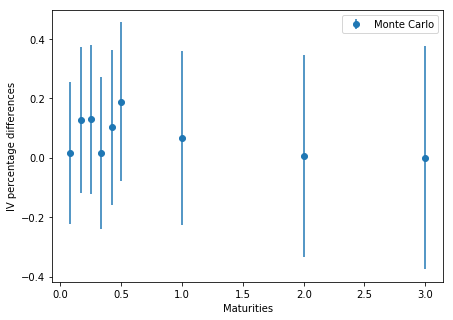

In [31]:
plt.figure(figsize=(7,5))
plt.errorbar(T,100*abs(imp_volatility-sigma[len(sigma)-1])/sigma[len(sigma)-1],yerr=[200*y_lower/sigma[len(sigma)-1],200*y_upper/sigma[len(sigma)-1]], fmt = "o", label = "Monte Carlo")
plt.xlabel("Maturities")
plt.ylabel("IV percentage differences")
plt.legend()
#plt.savefig("Monte_carlo_sigma_time_dep.pdf")
plt.show()